In [6]:
# Standard library modules
from collections import defaultdict
from pathlib import Path

# Third party modules
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = Path('../../../../data/Streamflow/fpe_stations')
JEFF_RESULTS_ROOT = Path('../../../../data/Streamflow/Jeff_data/stations')
# check if the data root exists
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Data root does not exist: {DATA_ROOT}")
if not JEFF_RESULTS_ROOT.exists():
    raise FileNotFoundError(f"Jeff results root does not exist: {JEFF_RESULTS_ROOT}")

jeff_results_dirs = list(JEFF_RESULTS_ROOT.glob('*'))

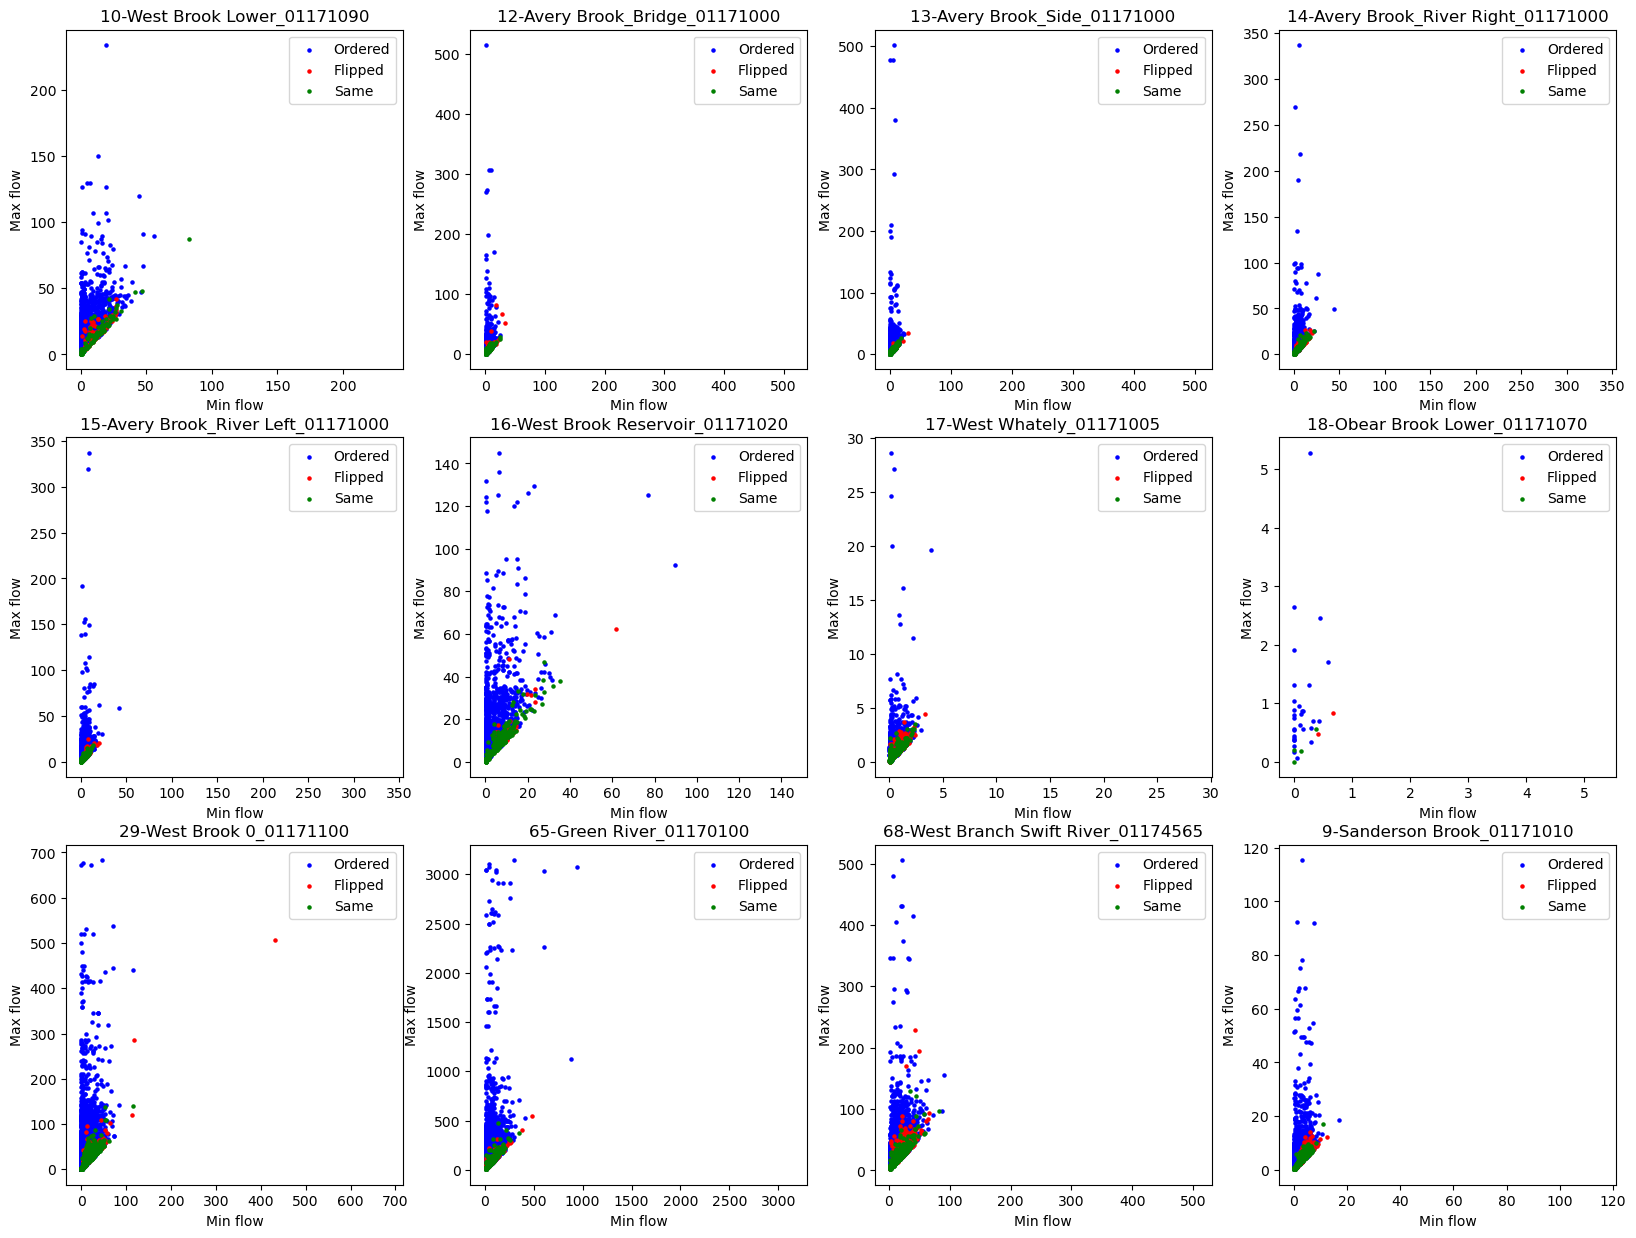

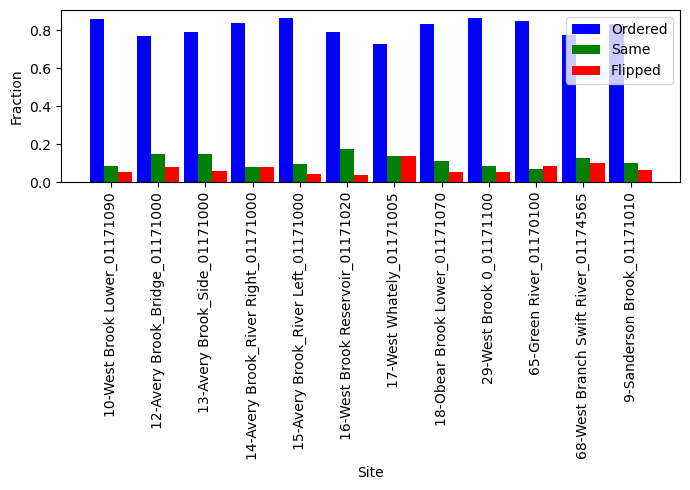

In [33]:
def check_annotations(site_pairs):
    n_annotations = len(site_pairs)
    # First, get counts of each label
    frac_same = (site_pairs['label'] == 0).sum() / n_annotations
    frac_left_higher = (site_pairs['label'] == 1).sum() / n_annotations
    frac_right_higher = (site_pairs['label'] == -1).sum() / n_annotations
    assert frac_same + frac_left_higher + frac_right_higher == 1, "Sum mismatch"
    
    # Next, get counts of each label for pairs with ground truth
    frac_have_gt = (site_pairs['value_1'].notnull() & site_pairs['value_2'].notnull()).sum() / n_annotations
    site_pairs_gt = site_pairs[site_pairs['value_1'].notnull() & site_pairs['value_2'].notnull()]
    assert len(site_pairs_gt) == (site_pairs['value_1'].notnull() & site_pairs['value_2'].notnull()).sum(), "Length mismatch"
    gt_label = [1 if v1 > v2 else -1 for v1, v2 in zip(site_pairs_gt['value_1'], site_pairs_gt['value_2'])]
    label = site_pairs_gt['label']
    assert len(gt_label) == len(label), f"Length mismatch: {len(gt_label)} != {len(label)}"
    frac_ordered = sum([1 for l, gt in zip(label, gt_label) if l == gt]) / len(label)
    frac_flipped = sum([1 for l, gt in zip(label, gt_label) if l != gt and l != 0]) / len(label)
    frac_same_gt = sum([1 for l in label if l == 0]) / len(label)
    ordered_pairs = site_pairs_gt[label == gt_label]
    flipped_pairs = site_pairs_gt[(label != gt_label) & (label != 0)]
    same_pairs = site_pairs_gt[label == 0]
    return n_annotations, frac_same, frac_left_higher, frac_right_higher, frac_have_gt, frac_ordered, frac_flipped, frac_same_gt, ordered_pairs, flipped_pairs, same_pairs

# Define marker styles and colors
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create lists to store the markers and colors for each site
site_markers = []
site_colors = []

check_annots_df = pd.DataFrame(columns=['n_annotations', 'frac_labeled_same', 'frac_labeled_left_higher', 'frac_labeled_right_higher', 'frac_have_gt', 'frac_ordered', 'frac_flipped', 'frac_same_gt'])
gt_pairs_info = defaultdict(dict)
for i, site_dir in enumerate(jeff_results_dirs):
    site_name = site_dir.name
    site_pairs_f = site_dir / 'input' / 'pairs.csv'
    site_pairs = pd.read_csv(site_pairs_f)
    n_annotations, frac_same, frac_left_higher, frac_right_higher, frac_have_gt, frac_ordered, frac_flipped, frac_same_gt, ord, flp, same = check_annotations(site_pairs)
    check_annots_df.loc[site_name] = [n_annotations, frac_same, frac_left_higher, frac_right_higher, frac_have_gt, frac_ordered, frac_flipped, frac_same_gt]
    ord_min_flow = [min(v1, v2) for v1, v2 in zip(ord['value_1'], ord['value_2'])]
    ord_max_flow = [max(v1, v2) for v1, v2 in zip(ord['value_1'], ord['value_2'])]
    flp_min_flow = [min(v1, v2) for v1, v2 in zip(flp['value_1'], flp['value_2'])]
    flp_max_flow = [max(v1, v2) for v1, v2 in zip(flp['value_1'], flp['value_2'])]
    same_min_flow = [min(v1, v2) for v1, v2 in zip(same['value_1'], same['value_2'])]
    same_max_flow = [max(v1, v2) for v1, v2 in zip(same['value_1'], same['value_2'])]
    gt_pairs_info[site_name] = {'ordered': [ord_min_flow, ord_max_flow], 'flipped': [flp_min_flow, flp_max_flow], 'same': [same_min_flow, same_max_flow]}

    # Store the marker and color for this site
    site_markers.append(markers[i % len(markers)])
    site_colors.append(colors[i % len(colors)])

# Scatter plot of min vs. max flow for ordered, flipped, and same pairs at each site
n_subplots = len(jeff_results_dirs)
n_subplot_cols = 4
n_subplot_rows = n_subplots // n_subplot_cols
fig, ax = plt.subplots(nrows=n_subplot_rows, ncols=n_subplot_cols, figsize=(20, 5 * n_subplot_rows))
for i, site_dir in enumerate(jeff_results_dirs):
    site_name = site_dir.name
    subplot_r = i // n_subplot_cols
    subplot_c = i % n_subplot_cols
    ax[subplot_r, subplot_c].scatter(gt_pairs_info[site_name]['ordered'][0], gt_pairs_info[site_name]['ordered'][1], label='Ordered', marker='o', color='b', s=5)
    ax[subplot_r, subplot_c].scatter(gt_pairs_info[site_name]['flipped'][0], gt_pairs_info[site_name]['flipped'][1], label='Flipped', marker='o', color='r', s=5)
    ax[subplot_r, subplot_c].scatter(gt_pairs_info[site_name]['same'][0], gt_pairs_info[site_name]['same'][1], label='Same', marker='o', color='g', s=5)
    ax[subplot_r, subplot_c].set_xlabel('Min flow')
    ax[subplot_r, subplot_c].set_ylabel('Max flow')
    # keep xlim and ylim the same for this subplot
    xlim = ax[subplot_r, subplot_c].get_xlim()
    ylim = ax[subplot_r, subplot_c].get_ylim()
    ax[subplot_r, subplot_c].set_xlim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax[subplot_r, subplot_c].set_ylim(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    ax[subplot_r, subplot_c].legend()
    ax[subplot_r, subplot_c].set_title(site_name)
plt.show()


# Bar plot of fraction of pairs ranked correctly vs. fraction of pairs ranked and fraction of pairs flipped vs. fraction of pairs ranked same
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
bar_width = 0.3
labels = ['Ordered', 'Same', 'Flipped']
colors = ['b', 'g', 'r']

for i, site_dir in enumerate(jeff_results_dirs):
    site_name = site_dir.name
    fractions = [check_annots_df.loc[site_name, 'frac_ordered'], check_annots_df.loc[site_name, 'frac_same_gt'], check_annots_df.loc[site_name, 'frac_flipped']]
    x = [i - bar_width, i, i + bar_width]
    for j in range(3):
        if i == 0:  # add labels only for the first group to avoid repeating legends
            ax.bar(x[j], fractions[j], bar_width, label=labels[j], color=colors[j])
        else:
            ax.bar(x[j], fractions[j], bar_width, color=colors[j])

ax.set_xticks(range(len(jeff_results_dirs)))
ax.set_xticklabels([site_dir.name for site_dir in jeff_results_dirs], rotation=90)
ax.set_xlabel('Site')
ax.set_ylabel('Fraction')
ax.legend()
plt.tight_layout()
plt.show()



# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
# for i, site_dir in enumerate(jeff_results_dirs):
#     site_name = site_dir.name
#     ax[0].scatter(check_annots_df.loc[site_name, 'frac_have_gt'], check_annots_df.loc[site_name, 'frac_ordered'], label=site_name, marker=site_markers[i], color=site_colors[i])
#     ax[1].scatter(check_annots_df.loc[site_name, 'frac_have_gt'], check_annots_df.loc[site_name, 'frac_flipped'], label=site_name, marker=site_markers[i], color=site_colors[i])
# #     ax[0].scatter(frac_ranked[i], frac_correct[i], label=site_names[i], marker=site_markers[i], color=site_colors[i])
# #     ax[1].scatter(flow_stdev[i], frac_correct[i], label=site_names[i], marker=site_markers[i], color=site_colors[i])
# # ax[0].set_xlabel('Fraction of pairs ranked (i.e. not labeled "SAME")')
# # ax[0].set_ylabel('Fraction of pairs ranked correctly')
# # ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
# # ax[0].set_title('Fraction of pairs ranked correctly vs. fraction of pairs ranked')
# # ax[1].set_xlabel('Standard deviation of flow predictions')
# # ax[1].set_ylabel('Fraction of pairs ranked correctly')
# # ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
# # ax[1].set_title('Fraction of pairs ranked correctly vs. standard deviation of flow predictions')
# plt.show()